In [1]:
# LOAD LIBRARIES
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
from tensorflow.python.keras.callbacks import LearningRateScheduler
from tensorflow.python.keras.layers import Conv2D, MaxPool2D, Flatten, Dense, Dropout
from tensorflow.python.keras.models import Sequential
from keras.preprocessing.image import ImageDataGenerator
from keras.utils.vis_utils import plot_model
import matplotlib.pyplot as plt

# LOAD THE DATASET
train = pd.read_csv('../dataset/sign_mnist_train.csv')
test  = pd.read_csv('../dataset/sign_mnist_test.csv')

# DATA FOR FURTHER PROCESSING
# take only the 'label' column
y_train = train['label']
y_test = test['label']
# categorize / binarize it
label_binarizer = LabelBinarizer()
y_train = label_binarizer.fit_transform(y_train)
y_test = label_binarizer.fit_transform(y_test)
# for some reason this inferred 25 classes, which is not what we want
# y_train = to_categorical(y_train, num_classes=24)
# drop the 'label' column
x_train = train.drop(labels='label', axis=1)
x_test = test.drop(labels='label', axis=1)
# get the underlying ndarray
x_train = x_train.values
x_test = x_test.values
# normalize the pixel values
x_train = x_train / 255.0
x_test = x_test / 255.0
# reshape them to be 28x28x1 image-like
x_train = x_train.reshape(-1, 28, 28, 1)
x_test = x_test.reshape(-1, 28, 28, 1)

annealer = LearningRateScheduler(lambda x: 1e-3 * 0.95 ** x, verbose=0)
data_generator = ImageDataGenerator(rotation_range=10,
                                    zoom_range=0.10,
                                    width_shift_range=0.1,
                                    height_shift_range=0.1)

save_plots = True

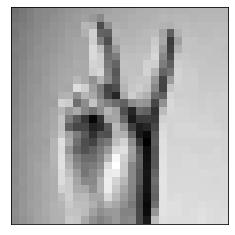

[0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
unique values: {0, 1, 2, 3, 4, 5, 6, 7, 8, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24}
min: 0, max: 24


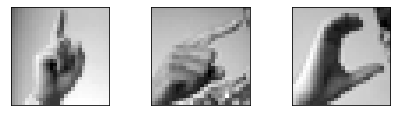

In [2]:
plt.tight_layout()
# plt.figure().set_size_inches(5, 5)
plt.imshow(x_train[21], cmap="gray")
axes = plt.gca()
axes.xaxis.set_visible(False)
axes.yaxis.set_visible(False)
if save_plots:
    plt.savefig('../plots/input_image.png',
                dpi=300,
                format='png',
                transparent=True,
                bbox_inches='tight')
plt.show()

# display first 3 images
train.head(3)


f, ax = plt.subplots(1, 3)
# f.set_size_inches(5, 10)

plt.tight_layout()

for i in range(3):
    ax[i].imshow(x_train[i], cmap="gray")
    print(y_train[i])
    ax[i].axes.xaxis.set_visible(False)
    ax[i].axes.yaxis.set_visible(False)
if save_plots:
    plt.savefig('../plots/input_first_three.png',
                dpi=300,
                format='png',
                transparent=True,
                bbox_inches='tight')

print('unique values:', set(train['label'].values))
print('min: {}, max: {}'.format(train['label'].values.min(),
                                train['label'].values.max()))

In [3]:
model = Sequential([
    # 2D convolution layer
    Conv2D(filters=32,  # number of neurons, found out through experiments
           kernel_size=(5, 5),
           strides=(1, 1),
           padding='valid', # no padding
           activation='relu',
           input_shape=(28, 28, 1), # first layer in model
                                    # (height x width x channels)
           data_format='channels_last',
           name='input_layer'),
    # use max pooling since we want to extract the most salient features
    # rather than average features
    MaxPool2D(pool_size=(2, 2),
              strides=(2, 2),
              padding='valid', # no padding
              name='max_pool_1'),
    Dropout(rate=0.3,
            seed=None,
            name='dropout_1'),

    Conv2D(filters=64,
           kernel_size=(5, 5),
           strides=(1, 1),
           padding='valid',
           activation='relu',
           name='second_conv2D'),
    MaxPool2D(pool_size=(2, 2),
              strides=(2, 2),
              padding='valid',
              name='max_pool_2'),
    Dropout(rate=0.3,
            seed=None,
            name='dropout_2'),

    Flatten(name='flatten'),
    Dense(units=128, activation='relu', name='dense'),
    Dropout(rate=0.3,
            seed=None,
            name='dropout_3'),
    Dense(units=24,
          activation='softmax',
          name='output_layer')
])
model._name="Sign_MNIST_CNN"
model.summary() # print model summary
model.compile(optimizer="adam",
              loss="categorical_crossentropy",
              metrics=["accuracy"])

print('model.submodules[0].input_shape:', model.submodules[0].input_shape)
print('model.metrics_names:', model.metrics_names)

if save_plots:
    plot_model(model,
               to_file='../plots/model_plot.png',
               show_shapes=True,
               show_layer_names=False,
               rankdir='TB',
               dpi=200)

Model: "Sign_MNIST_CNN"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (Conv2D)         (None, 24, 24, 32)        832       
_________________________________________________________________
max_pool_1 (MaxPooling2D)    (None, 12, 12, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 12, 12, 32)        0         
_________________________________________________________________
second_conv2D (Conv2D)       (None, 8, 8, 64)          51264     
_________________________________________________________________
max_pool_2 (MaxPooling2D)    (None, 4, 4, 64)          0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 4, 4, 64)          0         
_________________________________________________________________
flatten (Flatten)            (None, 1024)           

In [4]:
# if set to 0.2 that means that 20% of training data will be used in
# evaluation set
x_train2, x_val, y_train2, y_val = \
    train_test_split(x_train,
                     y_train,
                     test_size=0.2,
                     # random_state=42, # only for testing
                     # shuffle=False) # only for testing
                     )

In [5]:
# without data augmentation
# history = model.fit(x_train2,
#                     y_train2,
#                     batch_size=64, # maybe change to 64!?
#                     epochs=10,
#                     validation_data=(x_val, y_val),
#                     callbacks=[annealer],
#                     verbose=1)

# with data augmentation
history = model.fit(data_generator.flow(x_train2, y_train2, batch_size=64),
                    batch_size=64,
                    epochs=10,
                    validation_data=(x_val, y_val),
                    callbacks=[annealer],
                    verbose=1)

print("\nTrain accuracy={}, Validation accuracy={}\n".format(
        max(history.history['accuracy']), max(history.history['val_accuracy'])))

results = model.evaluate(x_test, y_test, verbose=1)
print("\ntest loss, test acc:", results)
print(model.metrics_names)

Epoch 1/10
344/344 [==============================] - 5s 12ms/step - loss: 2.8833 - accuracy: 0.1396 - val_loss: 0.8882 - val_accuracy: 0.7924

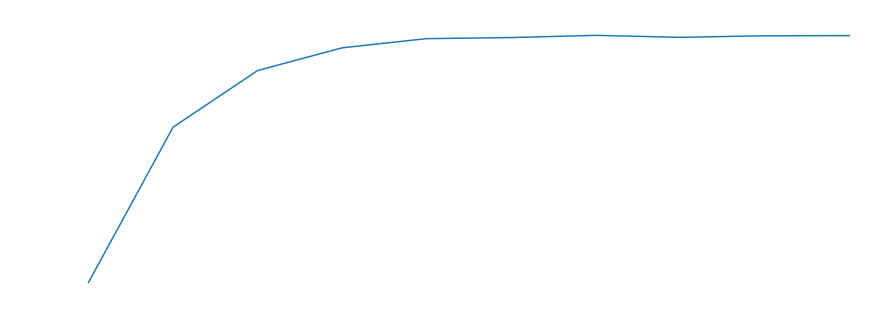

In [6]:
# PLOT ACCURACIES
f = plt.figure(figsize=(15, 5))
params = {"ytick.color" : "w",
          "xtick.color" : "w",
          "axes.labelcolor" : "w",
          "axes.edgecolor" : "w"}
plt.rcParams.update(params)

title_obj = plt.title('validation accuracy') #get the title property handler
plt.setp(title_obj, color='w')

plt.plot(history.history['val_accuracy'])

plt.ylabel('accuracy')
plt.xlabel('epoch')
axes = plt.gca()
if save_plots:
    plt.savefig('../plots/main_result.png',
                dpi=f.dpi, format='png',
                transparent=True)
plt.show()